# Regression

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
import warnings
from sklearn.model_selection import cross_val_score, train_test_split
# warnings.filterwarnings('ignore')
%matplotlib inline
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test_o = test.copy()
# pd.read_csv

## Exploracion.
Veamos que tipo de datos hay en ambos conjuntos (entrenamiento y prueba).

In [99]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [100]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Se puede excluir la columna **Id**, no aporta nada a ninguno de los conjuntos.

The train data size before dropping Id feature is: (1460, 81)
The test data size before dropping Id feature is: (1459, 80)
The train data size after dropping Id feature is: (1460, 80)
The test data size after dropping Id feature is: (1459, 79)


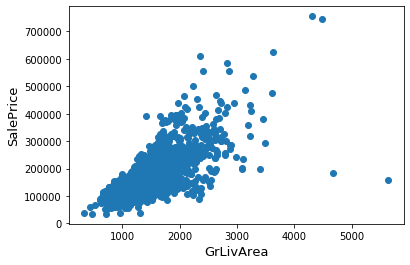

In [101]:
print('The train data size before dropping Id feature is: {}'.format(train.shape))
print('The test data size before dropping Id feature is: {}'.format(test.shape))

# Save the id column
train_id = train['Id']
test_id = test['Id']

train.drop('Id', axis=1, inplace = True)
test.drop('Id', axis=1, inplace= True)

print('The train data size after dropping Id feature is: {}'.format(train.shape))
print('The test data size after dropping Id feature is: {}'.format(test.shape))
# The train data size before dropping Id feature is: (1460, 81)
# The test data size before dropping Id feature is: (1459, 80)
# The train data size after dropping Id feature is: (1460, 80)
# The test data size after dropping Id feature is: (1459, 79)
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y= train['SalePrice'])
plt.xlabel('GrLivArea', fontsize=13)
plt.ylabel('SalePrice', fontsize=13)
plt.show()

Eliminar **outliers** del conjunto de entrenamiento para una mejor predicción.

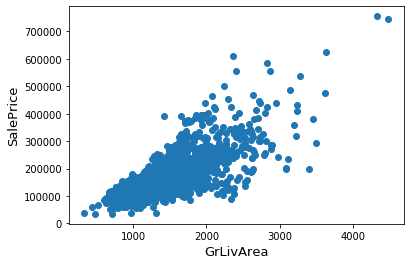

In [102]:
# Deleting outliers
train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice'] <300000)].index, inplace=True)
#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y= train['SalePrice'])
plt.xlabel('GrLivArea', fontsize=13)
plt.ylabel('SalePrice', fontsize=13)
plt.show()

La variable *target*: PriceSale esta **sesgada** a la derecha. Por lo que debemos transformala a una variable con distribución normal.

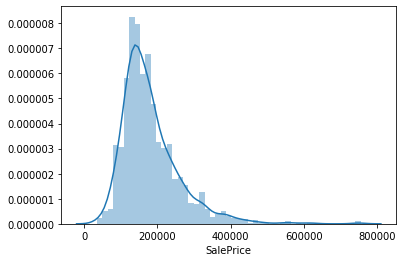

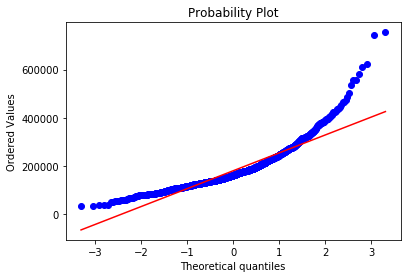

In [103]:
sns.distplot(train['SalePrice'])

# Get the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

Se hace uso de la funcion de *numpy.log1p()* porque es una forma de 'corregir' esta observación. A demás de que **log(0)** no está definido.

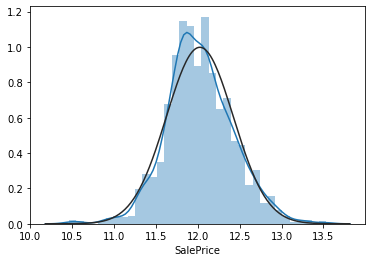

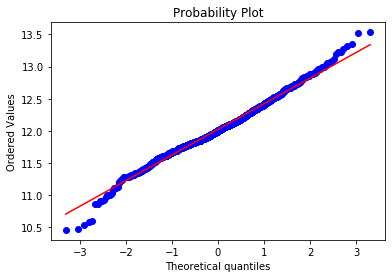

In [104]:
# We use the numpy function log1p which is log(1+x) to all elements of the column 
train['SalePrice'] = np.log1p(train['SalePrice'])

# Check the new distribution
sns.distplot(train['SalePrice'], fit=norm)

# Get the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

Ahora, obtener las variables que tengan datos **NaN** para después poder procesarlos.

In [105]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train,test)).reset_index(drop=True)
all_data.drop('SalePrice',axis=1, inplace = True)
print ('all_data size is :{}'.format(all_data.shape))
# all_data size is :(2917, 79)
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

all_data size is :(2917, 79)


,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageCond,5.450806
GarageFinish,5.450806
GarageYrBlt,5.450806


Podemos observar las distintas variables con sus repectivos porcentajes de la cantidad de datos 'Nulos'.

Text(0.5, 1.0, 'Percent missing data by feature')

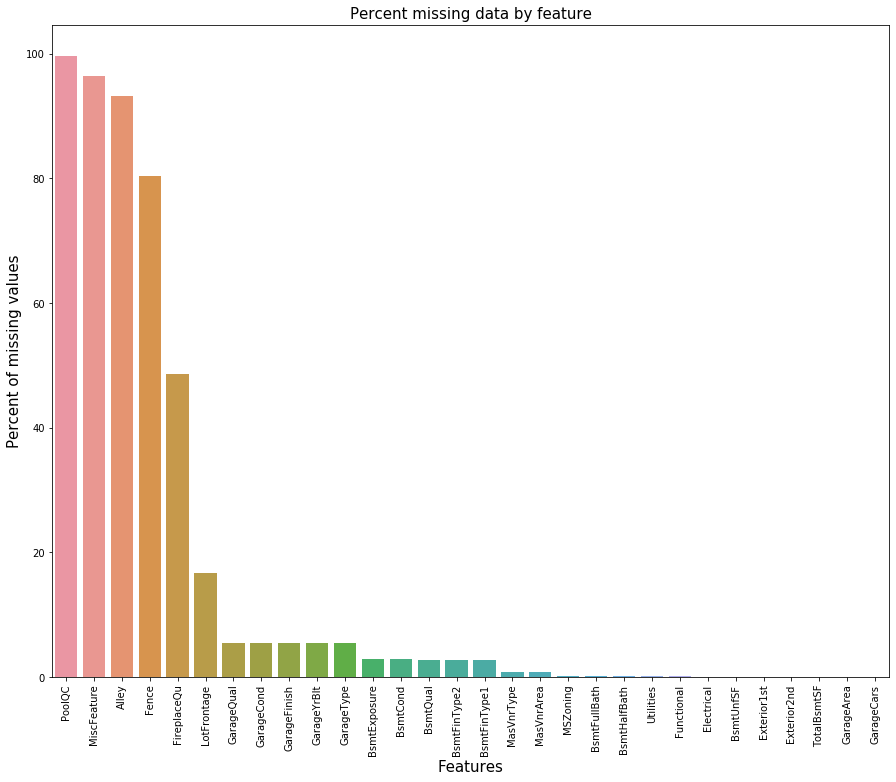

In [106]:
f, ax = plt.subplots(figsize=(15,12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
# Text(0.5,1,'Percent missing data by feature')

Es importante saber cuales son las variables que está correlacionadas, o sea que el valor de una puede 'influir' en el valor de otra. 

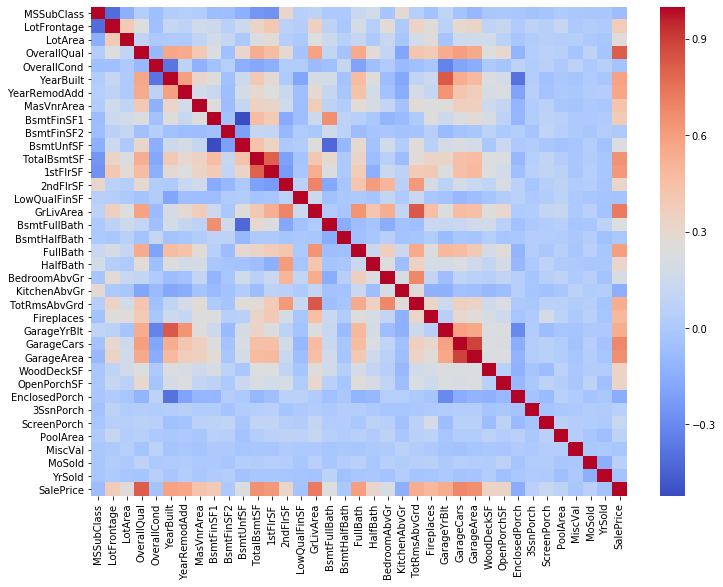

In [107]:
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, cmap='coolwarm')

Aquí llenamos valores NaN, dependiendo del tipo de dato. Puede ser con la media, un tipo de dato específico, etc

In [108]:
# PoolQC: data description says NA means "No Pool". That makes sense, given the huge ratio of missing value (+99%)
# and majority of houses have no Pool at all in general.
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')
# MiscFeature: data description says NA means 'no misc feature'
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')
# Alley: data description says NA means 'no alley access'
all_data['Alley'] = all_data['Alley'].fillna('None')
# Fence: data description says NA means 'no fence'
all_data['Fence'] = all_data['Fence'].fillna('None')
# FireplaceQu: data description says NA means 'no fireplace'
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')
all_data['LotFrontage']  = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


Ahora, tenemos que transformar varibles categoricas a numericas.

In [109]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))
# Shape all_data: (2917, 78)

all_data = pd.get_dummies(all_data)
print(all_data.shape)
(2917, 219)

train = all_data[:ntrain]
test = all_data[ntrain:]
X_train, X_test, y_train, y_test = train_test_split(train, y_train, test_size = 0.2, train_size = 0.8, random_state = 0)
# Define error measure for official scoring: RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv =10))
    return(rmse)

def rmse_cv_test(model):
    rmse = np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

Shape all_data: (2917, 78)
(2917, 219)


## Ridge regulation (L2 penalty)

Regularización es un método para manejar colinealidad, flitrar datos con ruido, provenir overfitting, etc. El concepto detras de la técnica es adicionar información (bias) para penalizar pesos de parametros extremos.

Simplemente agregamos la suma de los cuadrados de los pesos a nuestra función costo.

best alpha : 10.0
best alpha : 14.0
Ridge RMSE on Training set: 0.11656558821058163
Ridge RMSE on Test set: 0.13508163286717642


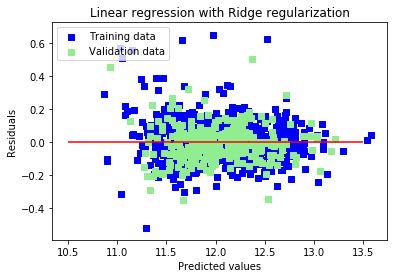

In [110]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print('best alpha : {}'.format(alpha))
# best alpha : 10.0

# Try again for more precision with alphas centered around

ridge = RidgeCV(alphas = [alpha *.6, alpha *.65, alpha *.7, alpha *.8, alpha*.9, alpha*.95, alpha, alpha *1.1,
                         alpha *1.25, alpha*1.3, alpha*1.35, alpha*1.4])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print('best alpha : {}'.format(alpha))
# best alpha : 14.0

print("Ridge RMSE on Training set: {}".format(rmse_cv_train(ridge).mean()))
print("Ridge RMSE on Test set: {}".format(rmse_cv_test(ridge).mean()))
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)
# Ridge RMSE on Training set: 0.11614145847848426
# Ridge RMSE on Test set: 0.12889005496454414

# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

Se puede observar, en ambas gráficas la aproximacion con los valores 'reales'.

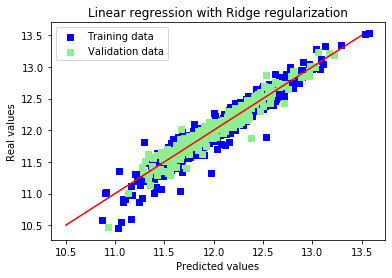

In [111]:
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

In [112]:
# predicts_ridge = ridge.predict(test)
# ridge_subm = pd.DataFrame({'Id': test_o.Id, 'SalePrice':predicts_ridge})
# ridge_subm.to_csv('sumbission_ridge.csv', index=False)

Ridge picked 215 features and eliminate the other4 features


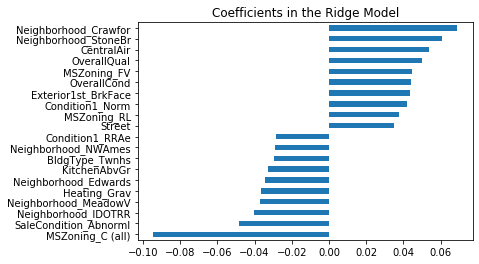

In [113]:
# Plot important coefficients 
coefs = pd.Series(ridge.coef_, index = X_train.columns)
num_coefs = sum(coefs !=0)
num_coefs_zero = sum(coefs ==0)
print ('Ridge picked {} features and eliminate the other{} features'.format(num_coefs, num_coefs_zero))
# Ridge picked 213 features and eliminate the other6 features
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

## Lasso regularization (L1 penalty)

LASSO (Least Absolute Shrinkage and Selection Operator):
Es una técnica alternativa para regularizar, donde simplemente remplazamos los cuadrados de los pesos por su valor absoluto. 

A diferencia de regularizacion L2, L1 resulta en vectores con características dispersas.

In [114]:
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1])
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha: {}".format(alpha))
# Best alpha: 0.0006

lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4])
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha: {}".format(alpha))
# Best alpha: 0.0005099999999999999

print("Lasso RMSE on Training set: {}".format(rmse_cv_train(lasso).mean()))
print("Lasso RMSE on Test set: {}".format(rmse_cv_test(lasso).mean()))
y_train_rdg = lasso.predict(X_train)
y_test_rdg = lasso.predict(X_test)
# Lasso RMSE on Training set: 0.11715192541377659
# Lasso RMSE on Test set: 0.12910741978991086

Best alpha: 0.0006
Best alpha: 0.0007499999999999999
Lasso RMSE on Training set: 0.117487860262281
Lasso RMSE on Test set: 0.14278934654766268


In [115]:
# predicts_lasso = lasso.predict(test)
# lasso_subm = pd.DataFrame({'Id': test_o.Id, 'SalePrice':predicts_lasso})
# lasso_subm.to_csv('sumbission_lasso.csv', index=False)